## Let's start with something really simple

Create a new object of type "Workflow"
![Screenshot 2025-01-22 at 15.25.24.png](attachment:47384d80-6ee5-4618-9ec8-260f82e2d123 =180x)

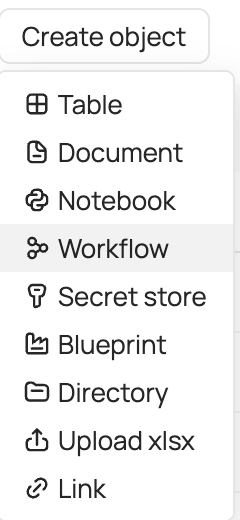
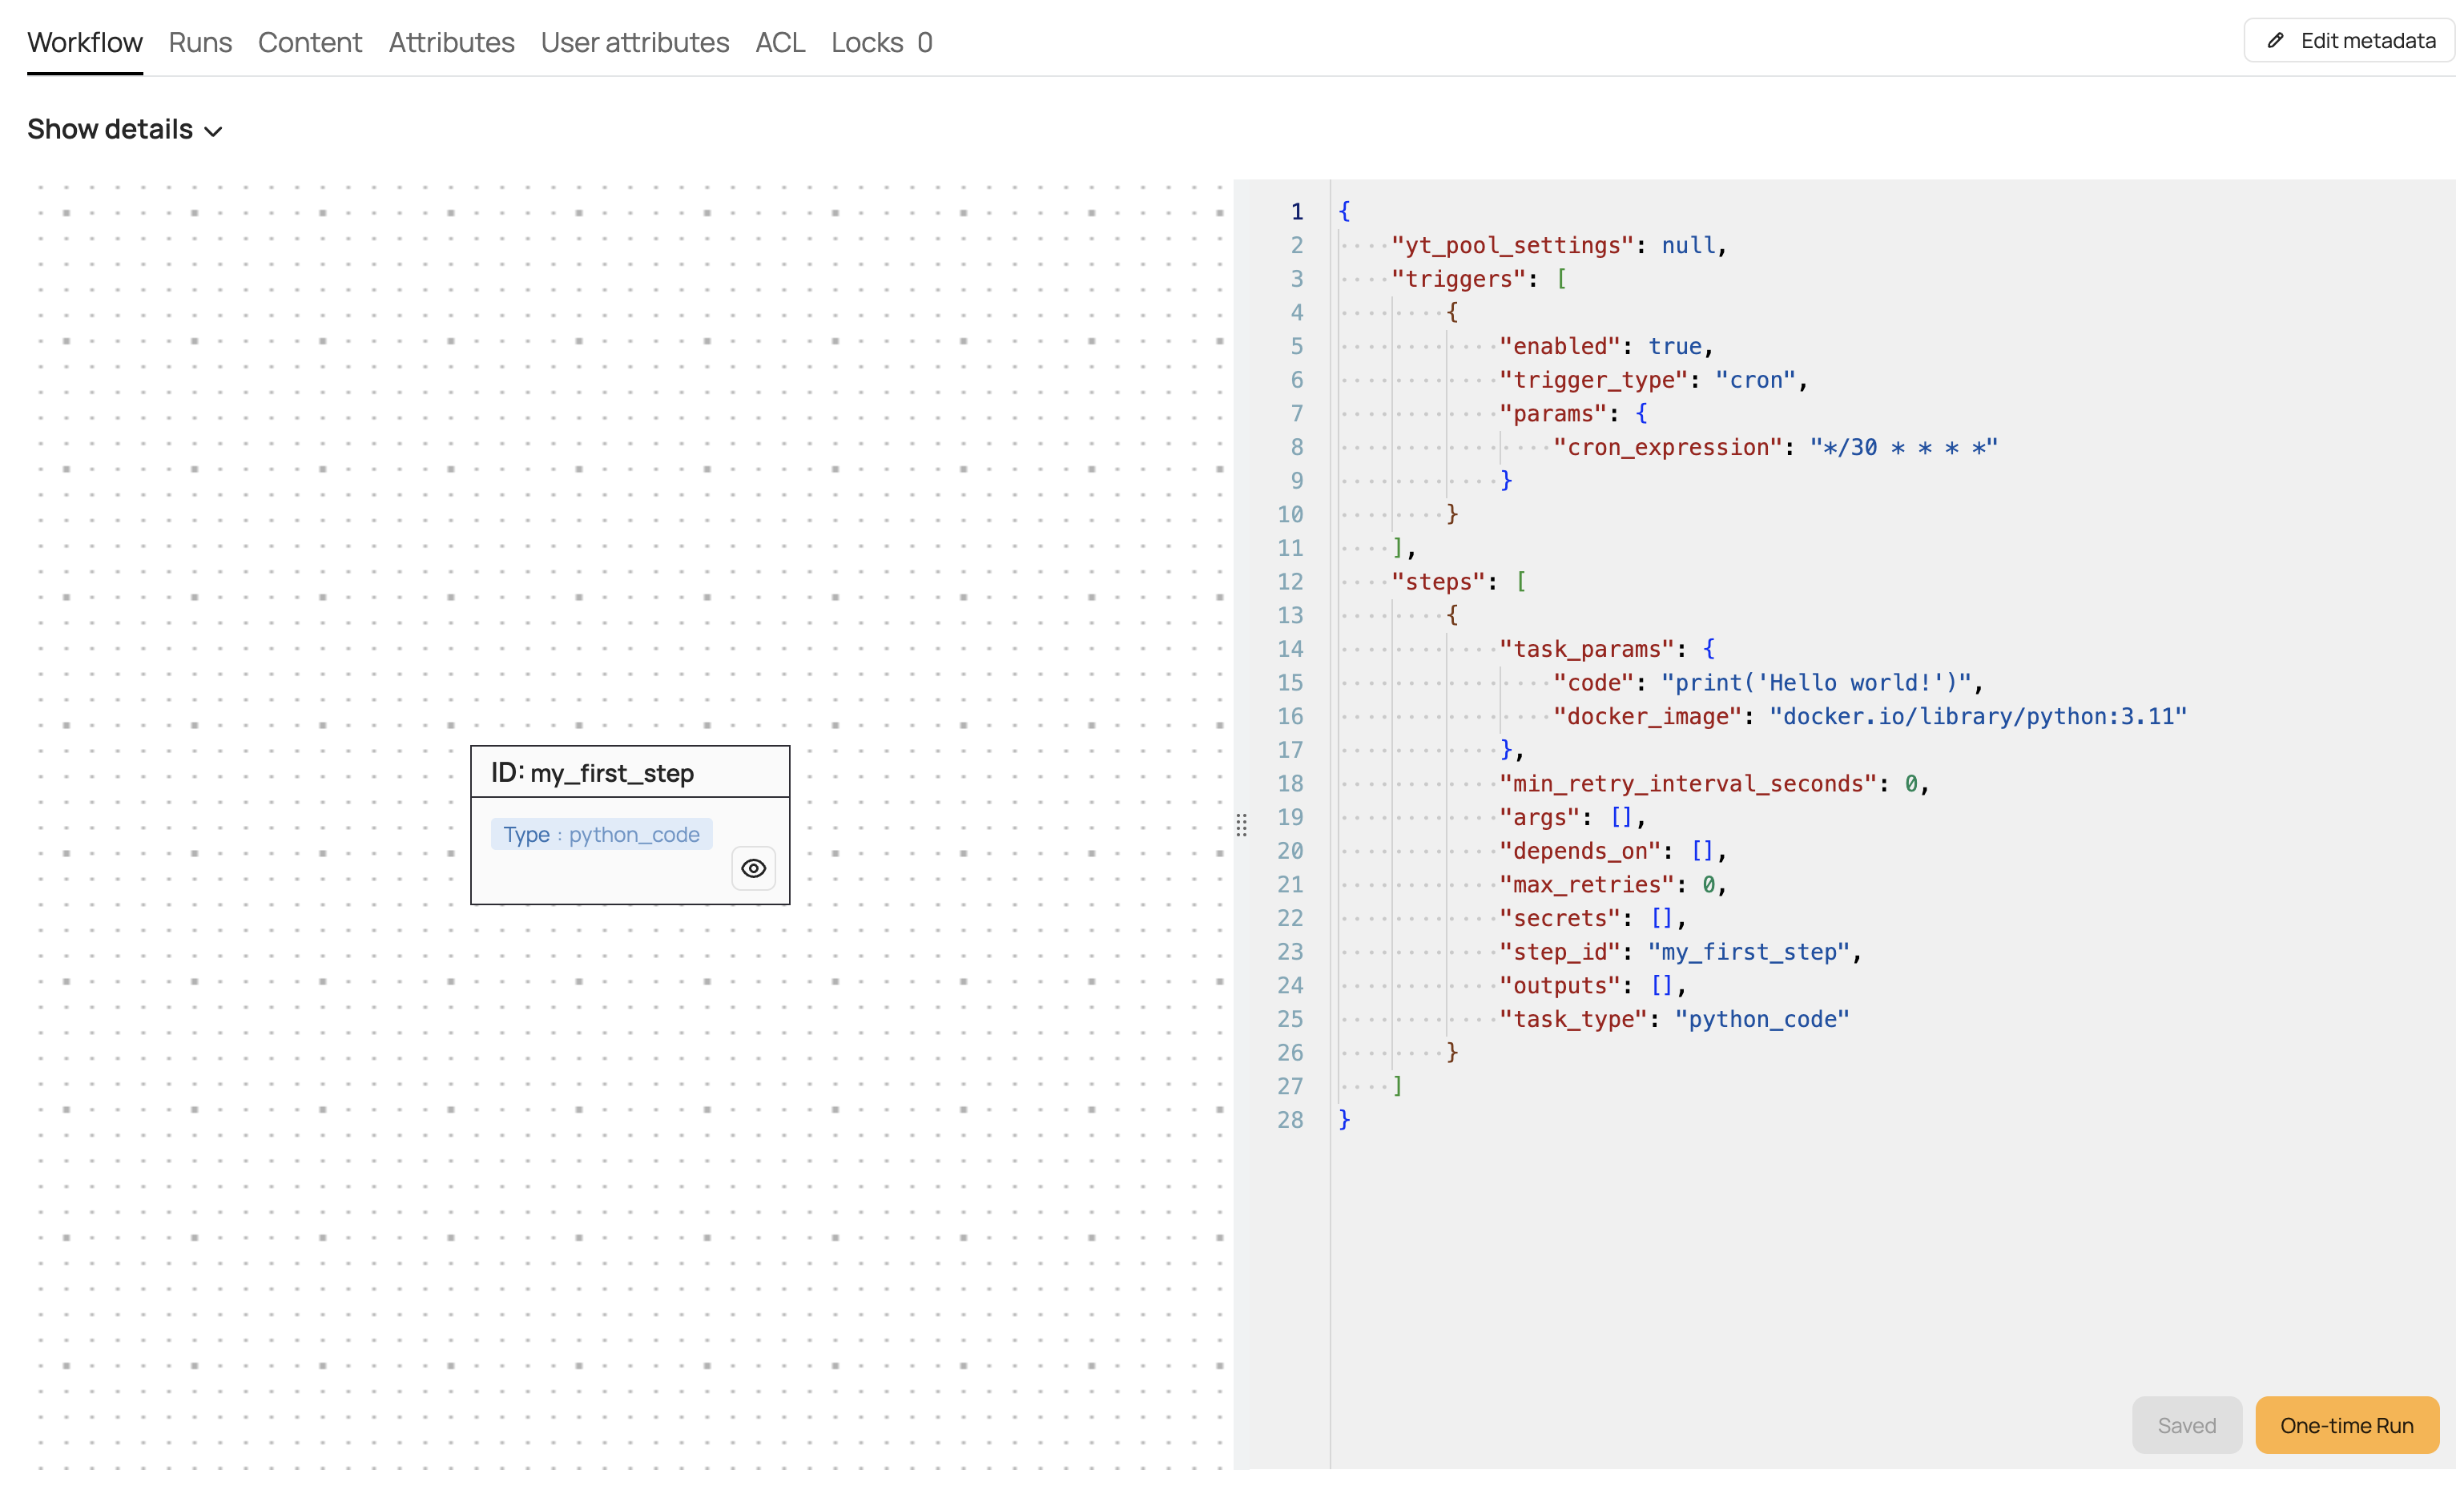
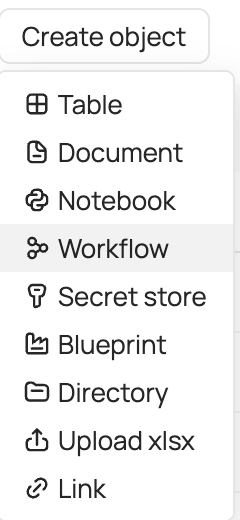
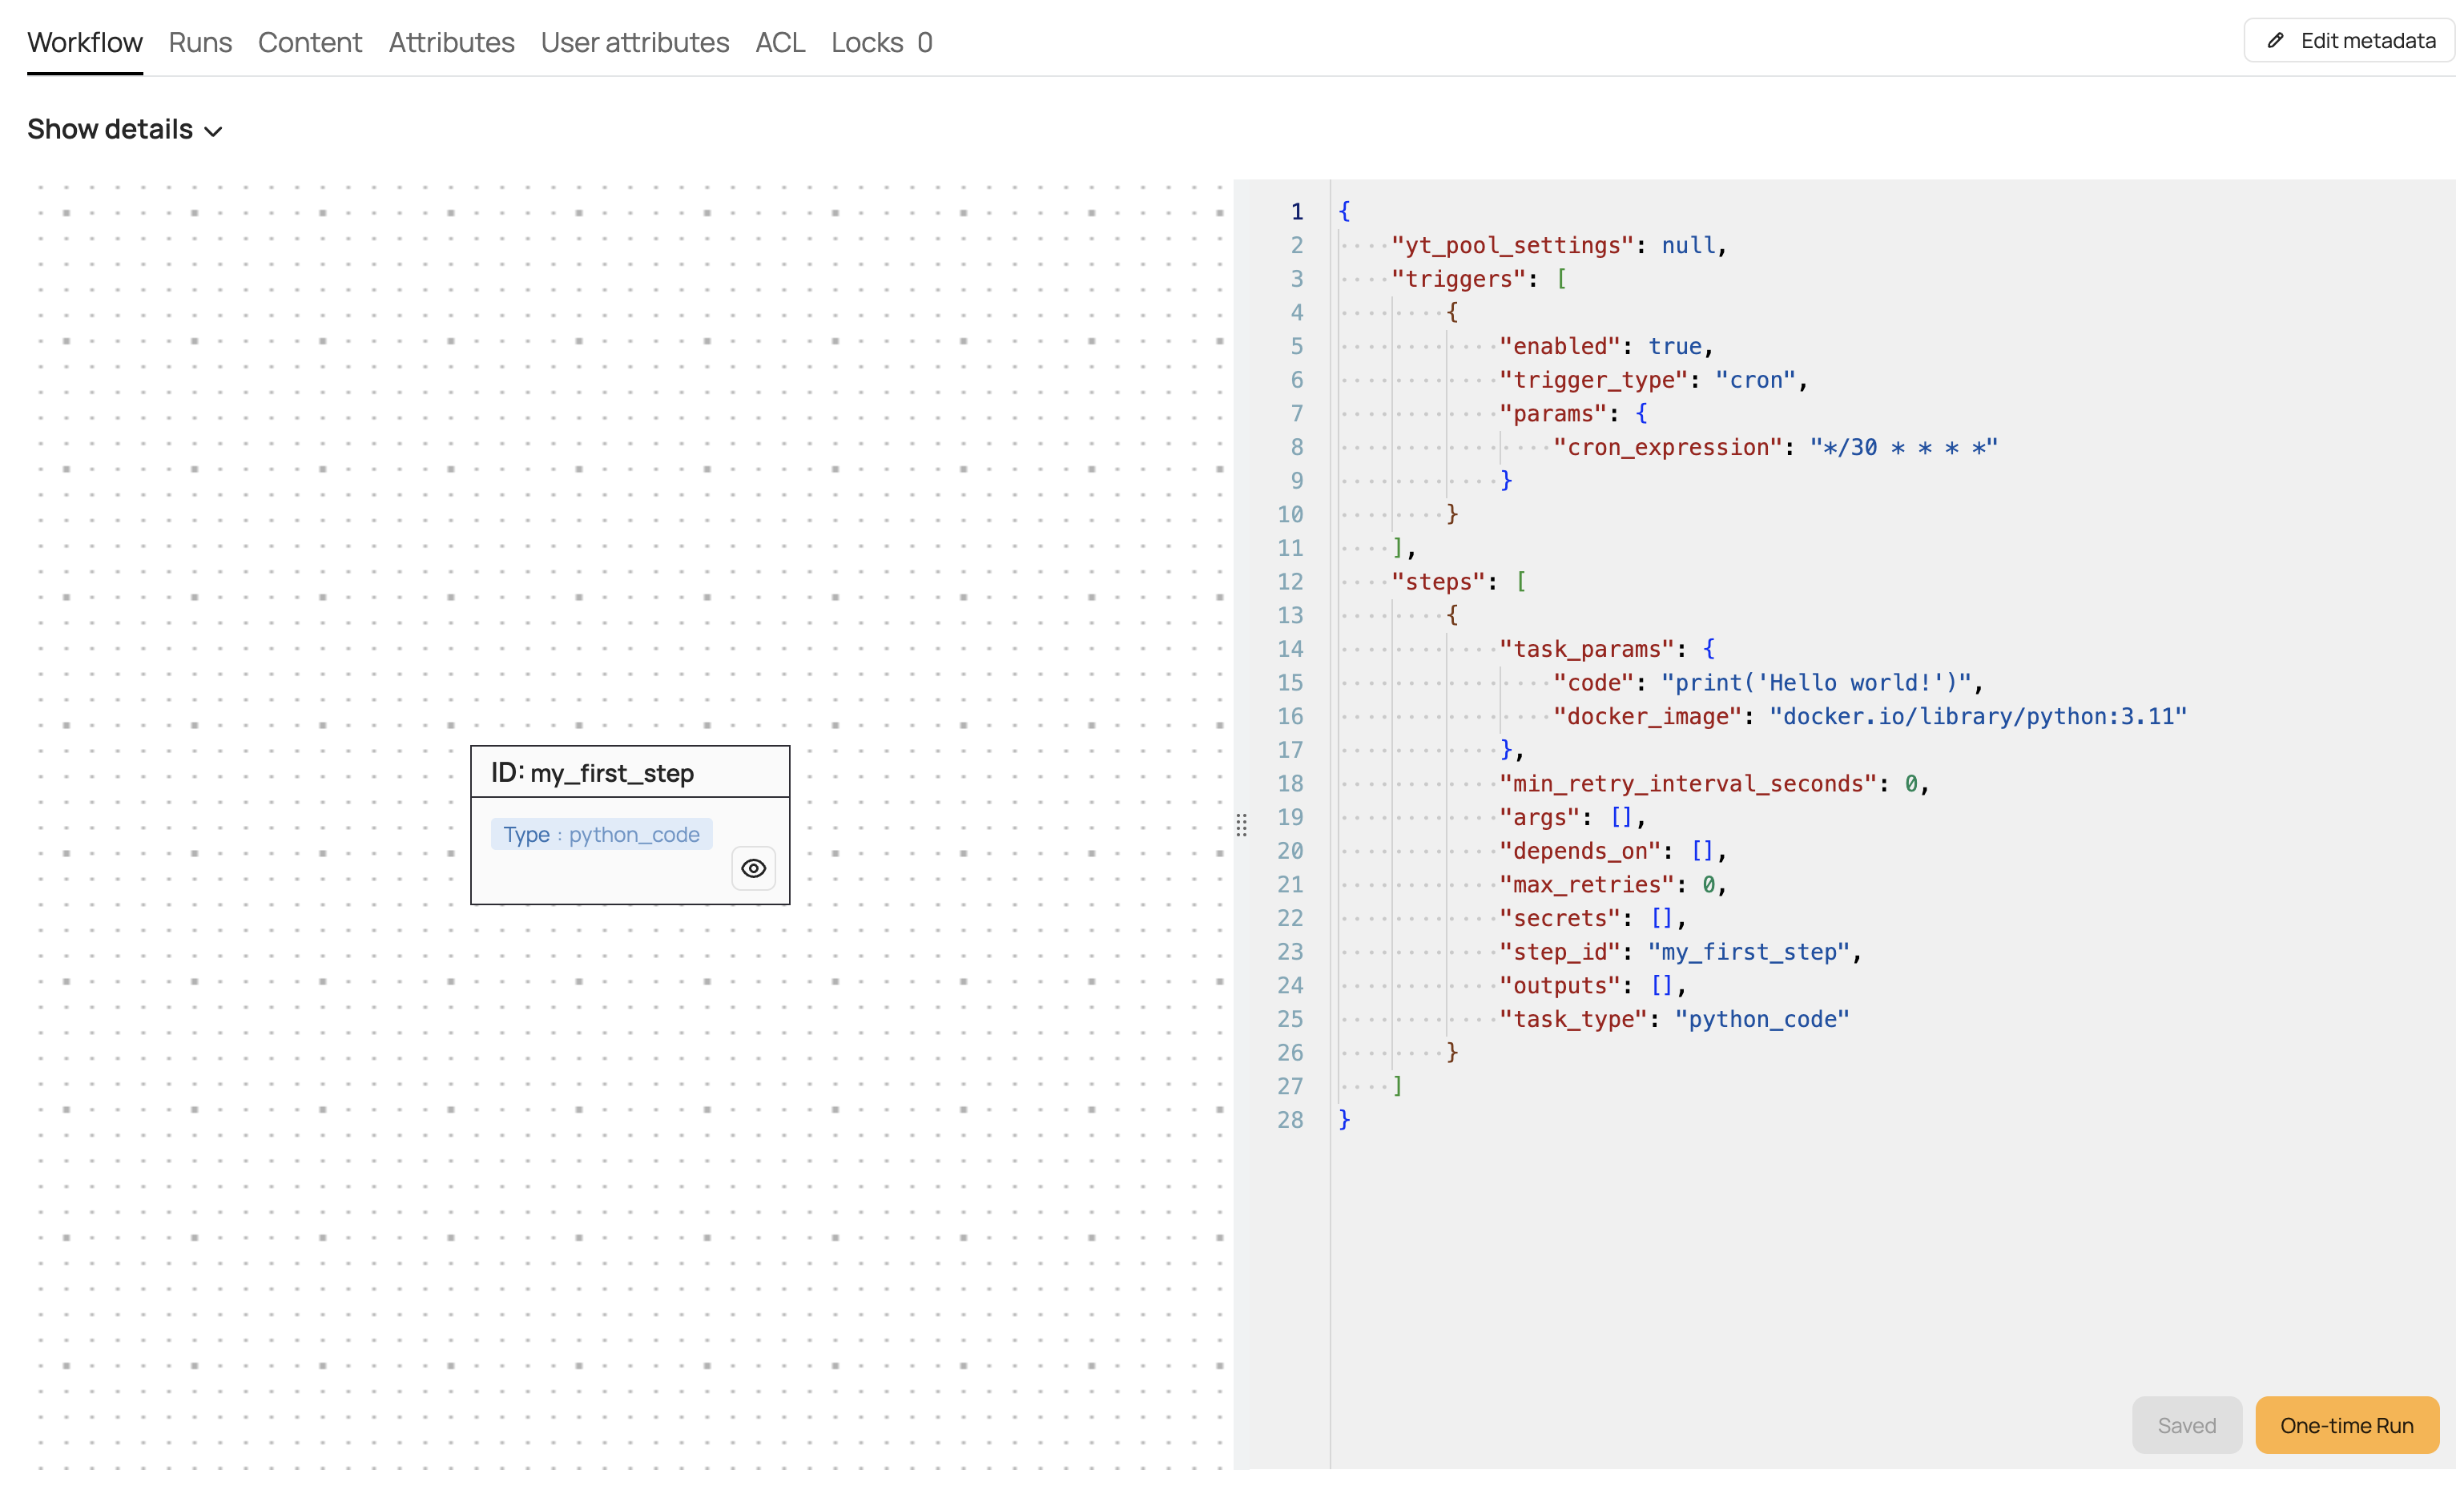
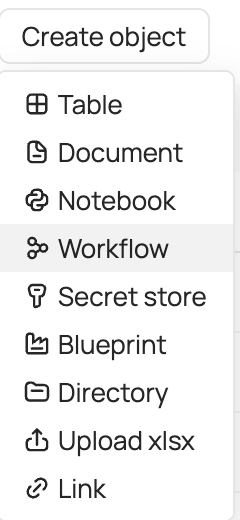

Some simple workflow will be created.
![Screenshot 2025-01-22 at 15.27.46.png](attachment:e68d49cf-8f81-4c95-b410-eaa095ee1eac =800x)

 You can press "One-time run" button and see it is running on the "Runs" tab.
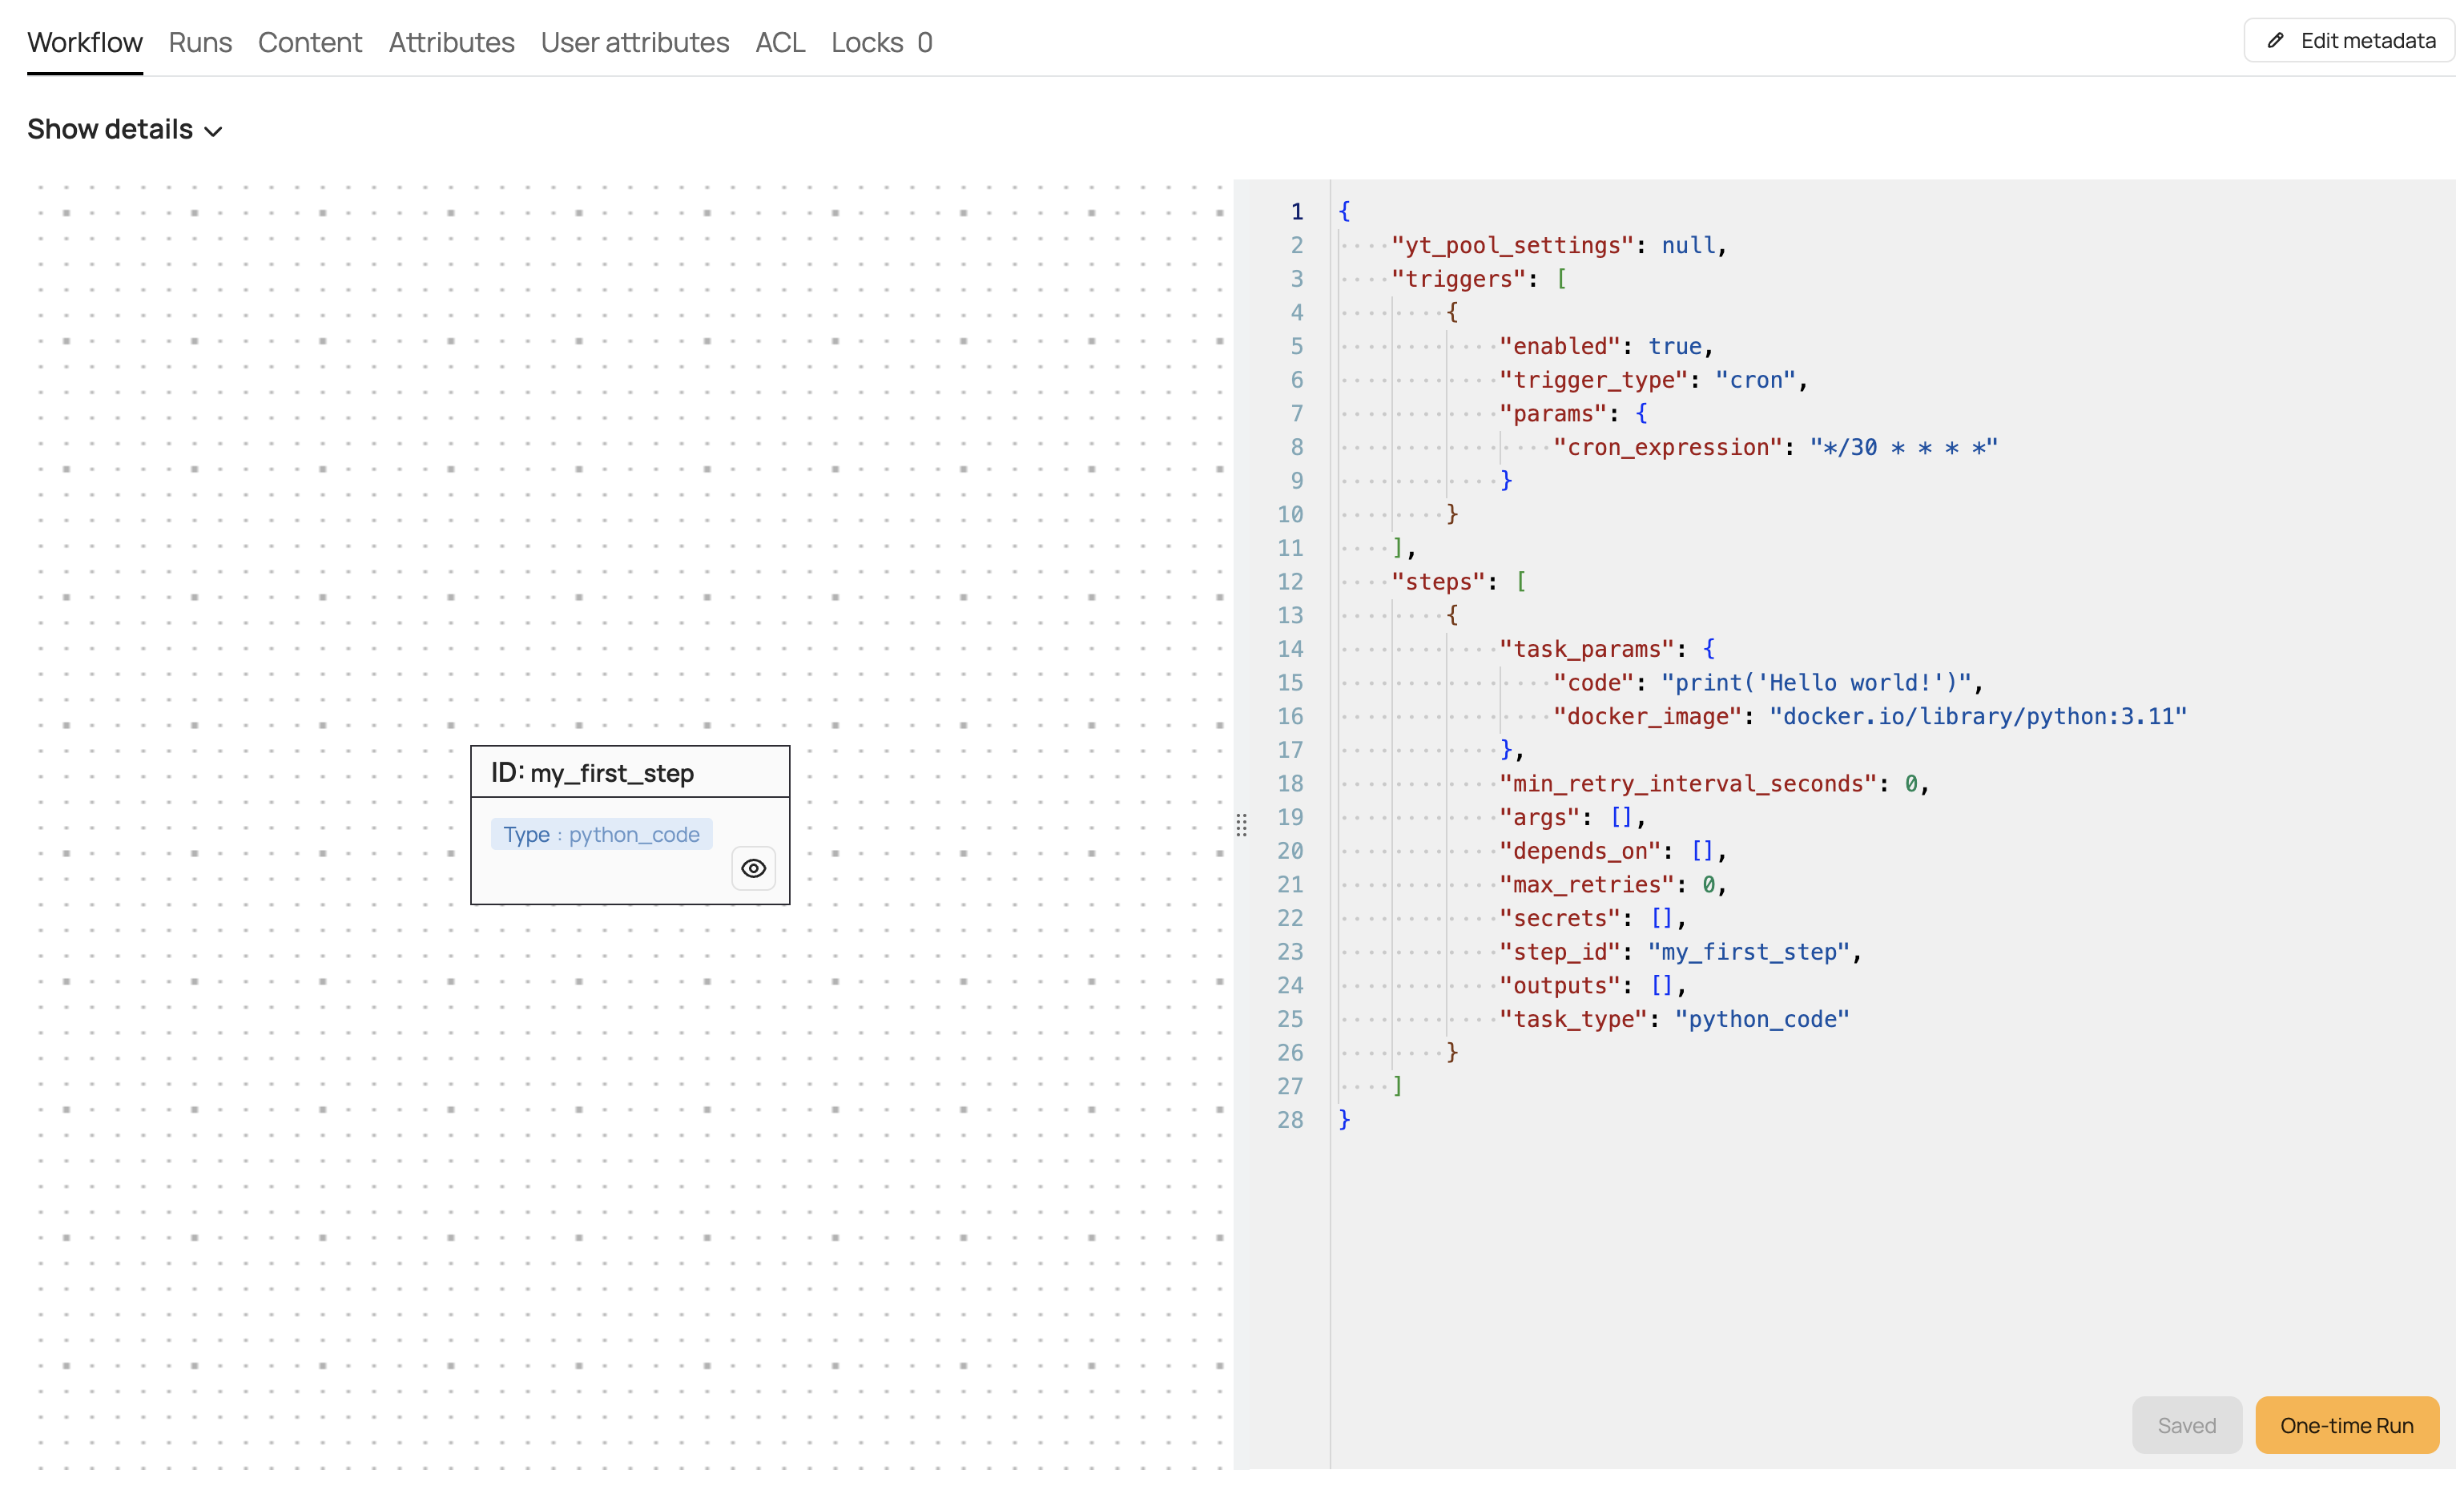

## Let's make something more complicated
In order to interact with YT from a workflow we need to provide a user token. Create a new secret store first:
 ![image.png](attachment:28cc9358-2996-4f7b-b008-0c0b84afbac0 =180x)

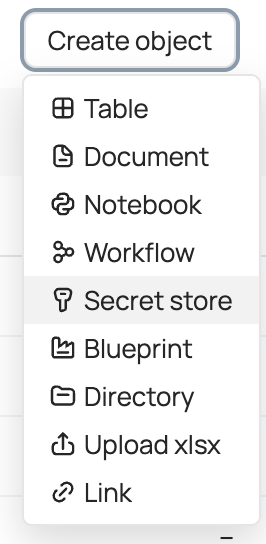

Create a new record in this store: save your YT token with key `token`. Save the secret.

![image.png](attachment:57979700-ca09-438a-8cbe-903feee82099 =750x) 
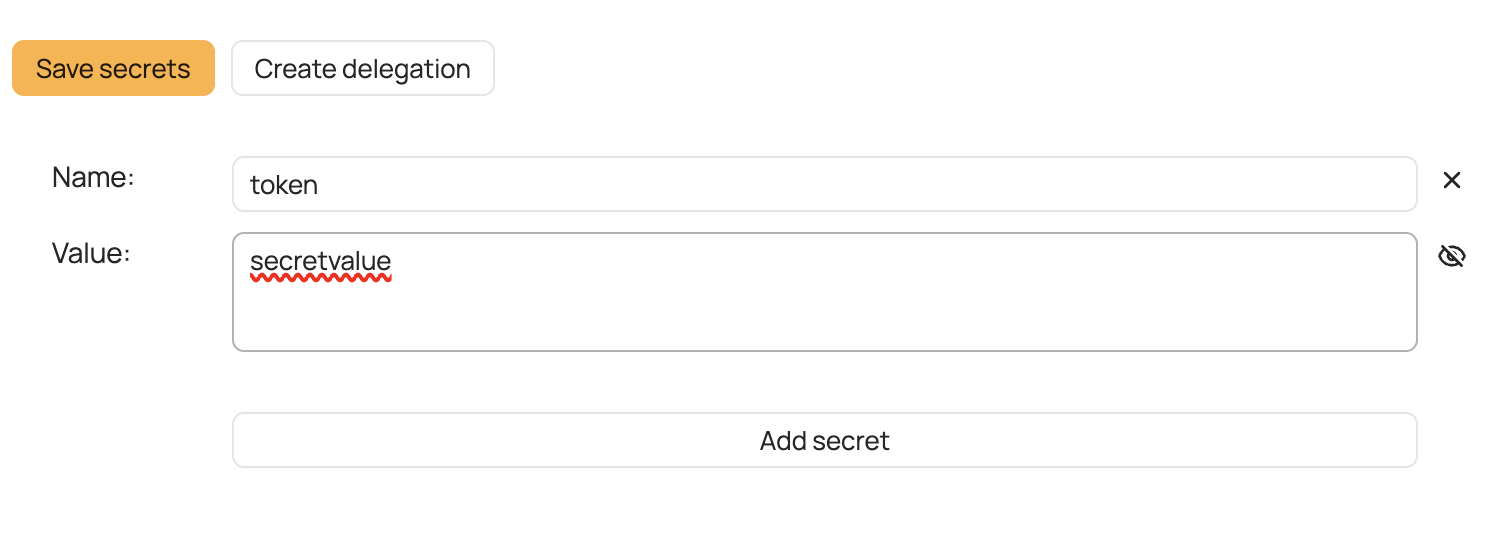

Now let's create a workflow. There are two ways to do that: via UI and via CLI.

## Creating workflow via UI

Just create a new workflow via `Create object -> Workflow` button. You will get a simple workflow consisting of one step. Let's make it a bit more interesting. Replace its config with the following one, but use your secret store's path from the previous step in `steps[0].secrets[0].value_ref`:

```json
{
    "_format_version": "0.1",
    "triggers": [
        {
            "trigger_type": "cron",
            "params": {
                "cron_expression": "*/30 * * * *"
            }
        }
    ],
    "steps": [
        {
            "step_id": "step_1",
            "task_type": "docker",
            "task_params": {
                "docker_image": "ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68",
                "command": "YT_TOKEN=$YT_SECURE_VAULT_YT_TOKEN yt start-query yql \"SELECT 42 as tweeenveertig\" >&2"
            },
            "secrets": [
                {
                    "key": "YT_TOKEN",
                    "value_src_type": "secret_store",
                    "value_ref": "//path/to/your/secret/store:token"
                }
            ]
        },
        {
            "step_id": "step_2_1",
            "task_type": "docker",
            "task_params": {
                "docker_image": "ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68",
                "command": "echo \"first child\" >&2"
            },
            "depends_on": ["step_1"]
        },
        {
            "step_id": "step_2_2",
            "task_type": "docker",
            "task_params": {
                "docker_image": "ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68",
                "command": "echo \"second child\" >&2"
            },
            "depends_on": ["step_1"]
        }
    ]
}
```

On the secret's page you can see that a new delegation has been created: it allows the workflow to use the secret. You can revoke the delegation on that page (and it will break the workflow).
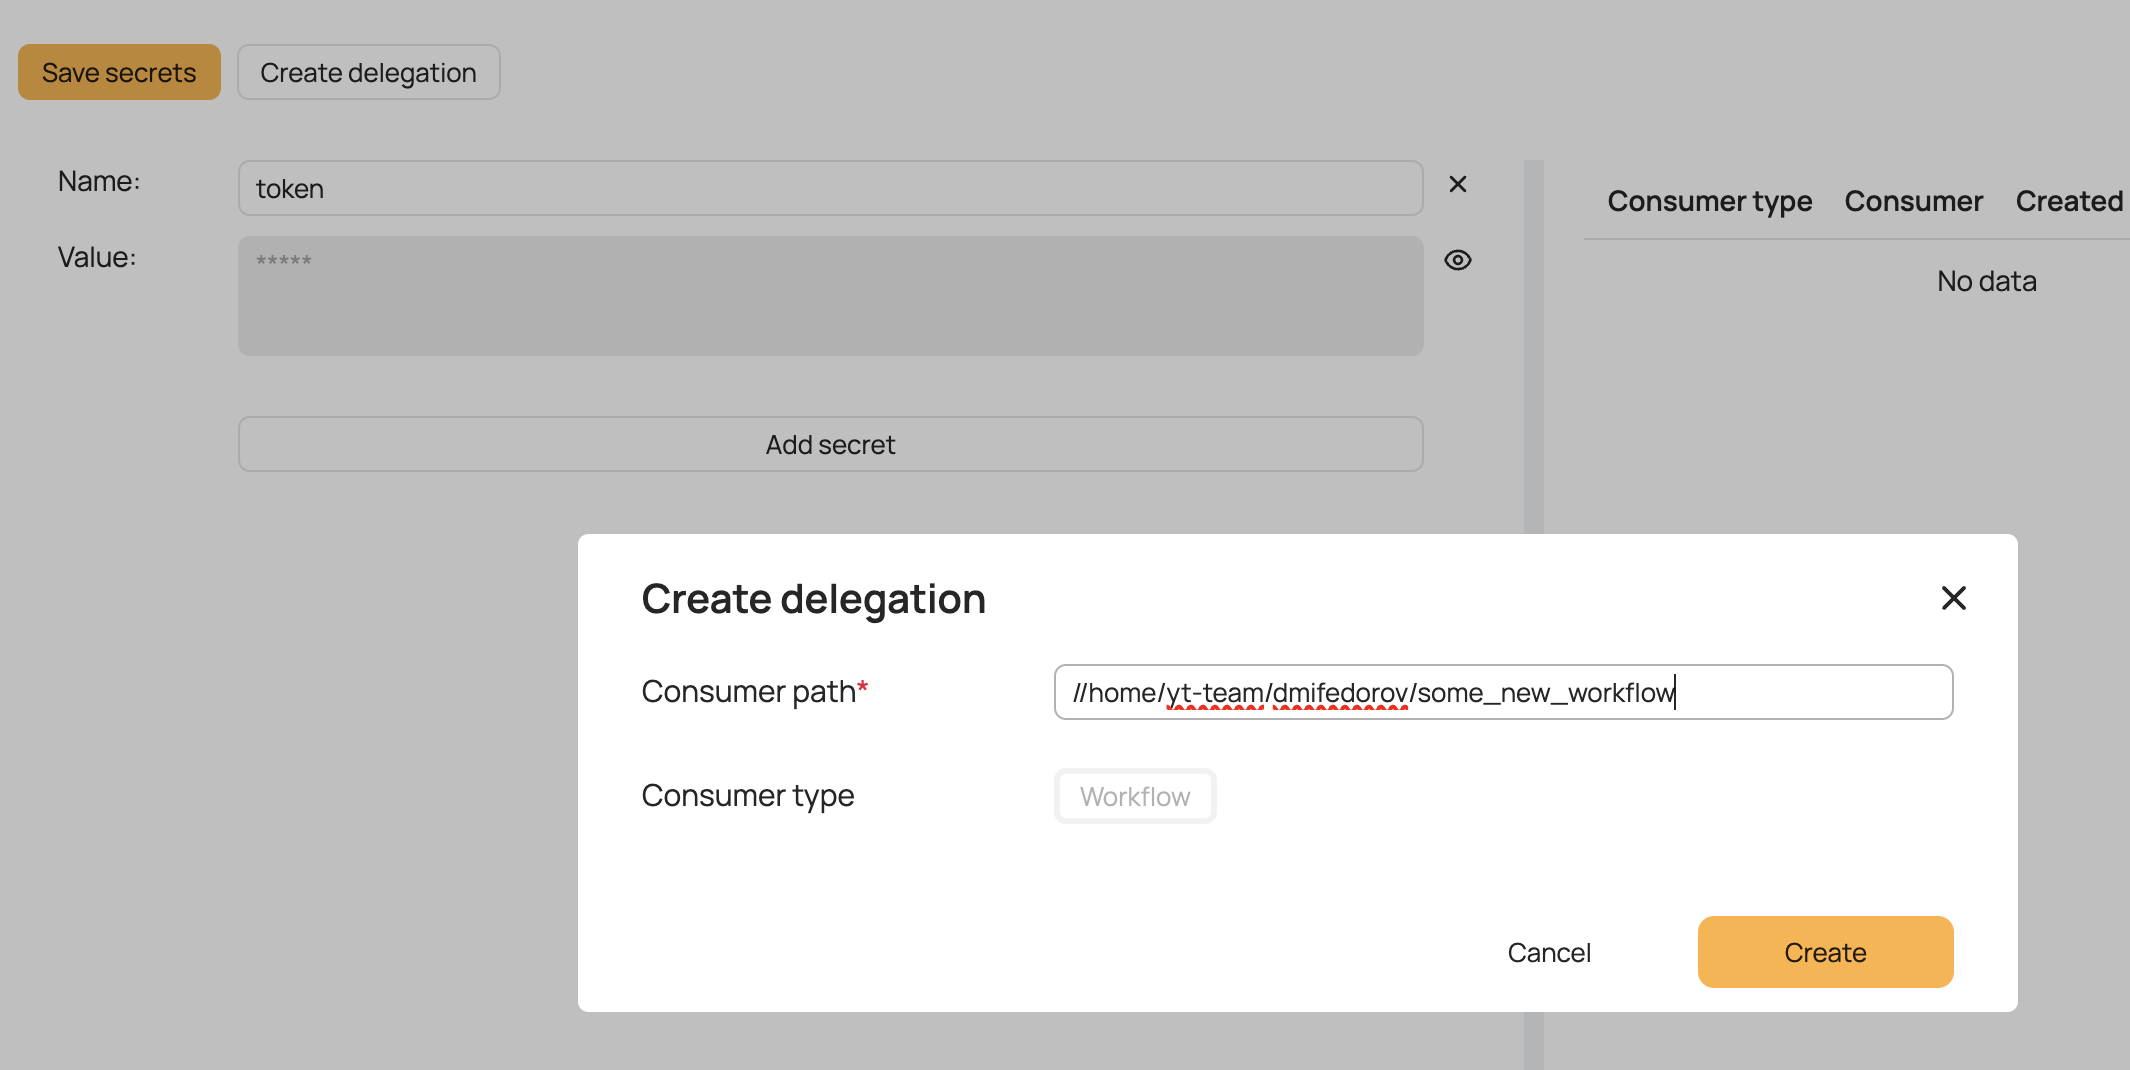

Now we can return to the workflow's page. Press "One time run" button to launch the workflow. Open the "Run" tab to see your new run.

And after some time the workflow must successfuly finish
![image.png](attachment:4cd2d439-6600-45a2-ad1f-2c9f39876ad6 =750x)
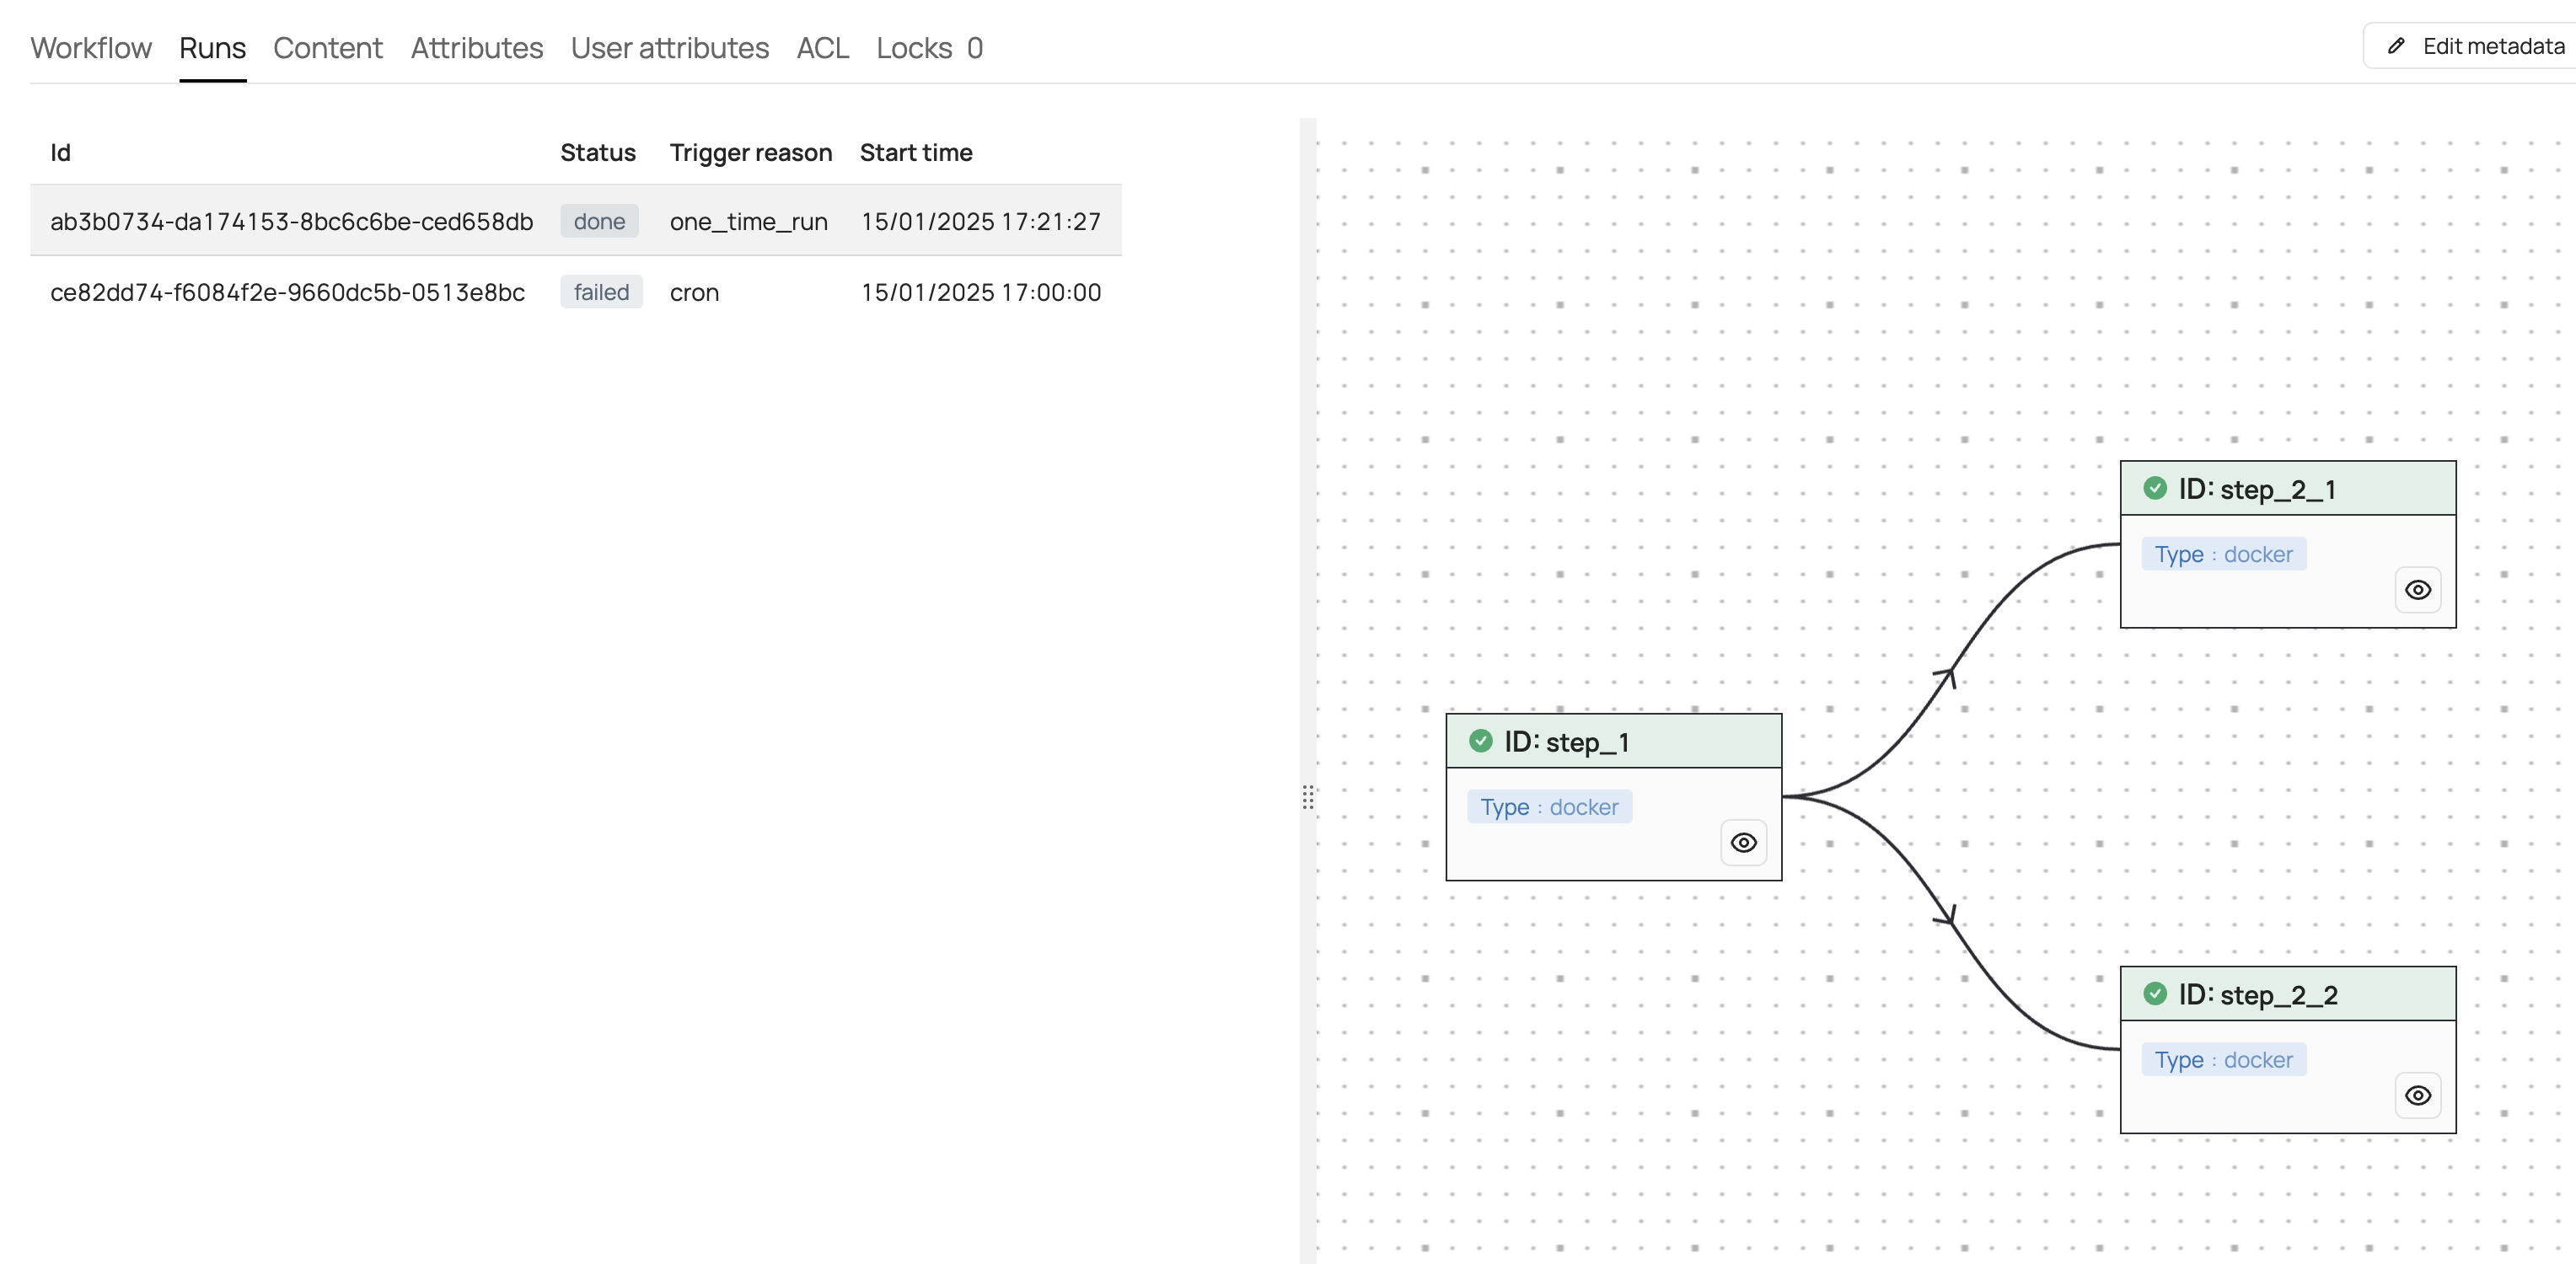

## Creating workflow via CLI

Install orchestracto client:

In [10]:
!pip install orchestracto-client

Here is our workflow in YAML format:

```yaml
---
_format_version: '0.1'
triggers:
- trigger_type: cron
  params:
    cron_expression: "*/30 * * * *"
steps:
- step_id: step_1
  task_type: docker
  task_params:
    docker_image: ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68
    command: YT_TOKEN=$YT_SECURE_VAULT_YT_TOKEN yt start-query yql "SELECT 42 as tweeenveertig" >&2
  secrets:
  - key: YT_TOKEN
    value_src_type: secret_store
    value_ref: "//path/to/your/secret/store:token"
- step_id: step_2_1
  task_type: docker
  task_params:
    docker_image: ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68
    command: echo "first child" >&2
  depends_on:
  - step_1
- step_id: step_2_2
  task_type: docker
  task_params:
    docker_image: ghcr.io/tractoai/notebook-kernel-default:2024-12-27-14-31-09-307b3bc68
    command: echo "second child" >&2
  depends_on:
  - step_1
  ```
Save it on your computer.

Prepare env:
```bash
export YT_PROXY=planck.yt.nebius.yt
export YT_TOKEN=...
```

 Then run
```bash
orc workflow update --wf-path //path/to/workflow/on/yt --from-file /local/path/to/workflow/config.yaml
```

This command will upload config on YT and register it in orchestracto. Now we can create a new run:
```bash
orc run create --wf-path //path/to/workflow/on/yt
```
The command will print ID of the run. You can use it to obtain run info:

In [12]:
!orc --format json run get --wf-path //home/yt-team/dmifedorov/some_new_workflow --run-id ab3b0734-da174153-8bc6c6be-ced658db | jq .stage

"done"


or logs:

In [14]:
!orc run get-logs --wf-path //home/yt-team/dmifedorov/some_new_workflow --run-id ab3b0734-da174153-8bc6c6be-ced658db | tail -n 5

ts=2025-01-15 16:21:55.226	name=orc.wf_executor.executor	level=INFO    	run_id=ab3b0734-da174153-8bc6c6be-ced658db	msg=Handling running steps
ts=2025-01-15 16:21:55.238	name=orc.wf_executor.executor	level=INFO    	run_id=ab3b0734-da174153-8bc6c6be-ced658db	msg=Checking running step step_2_2
ts=2025-01-15 16:21:55.491	name=orc.wf_executor.executor	level=INFO    	run_id=ab3b0734-da174153-8bc6c6be-ced658db	msg=step step_2_2 finished: failed=False
ts=2025-01-15 16:21:58.518	name=orc.wf_executor.executor	level=INFO    	run_id=ab3b0734-da174153-8bc6c6be-ced658db	msg=All steps have been done



You can also list runs:

In [16]:
!orc workflow get-runs --wf-path //home/yt-team/dmifedorov/some_new_workflow --limit 3

- created_at: '2025-01-15T16:30:02Z'
  finished_at: '2025-01-15T16:30:36Z'
  labels: []
  run_id: 66b92a3b-55f544bb-9ef0825d-11851e2e
  stage: done
  trigger_type: cron
  workflow_path: //home/yt-team/dmifedorov/some_new_workflow
- created_at: '2025-01-15T16:21:27Z'
  finished_at: '2025-01-15T16:22:03Z'
  labels: []
  run_id: ab3b0734-da174153-8bc6c6be-ced658db
  stage: done
  trigger_type: one_time_run
  workflow_path: //home/yt-team/dmifedorov/some_new_workflow
- created_at: '2025-01-15T16:00:00Z'
  finished_at: '2025-01-15T16:00:15Z'
  labels: []
  run_id: ce82dd74-f6084f2e-9660dc5b-0513e8bc
  stage: failed
  trigger_type: cron
  workflow_path: //home/yt-team/dmifedorov/some_new_workflow

